In [1]:
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pytoc import TOC, TOC_painter
import seaborn as sns
import scipy.stats as stats
import itertools
import os
import ee
from PIL import Image
import scikit_posthocs as sp

## 1. Data Preprocessing

In [2]:
# Initialize 
m = geemap.Map(center=[-31.4192, -64.19], zoom=11)
m

Map(center=[-31.4192, -64.19], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [3]:
# get current working path
cwp = os.getcwd()

In [4]:
# m.draw_features
# Load the data
roi_shp = cwp + "/data/cordoba_roi_20241204.shp"
roi = geemap.shp_to_ee(roi_shp)

# sample_shp = cwp + "/data/650sample_refine_20241123.shp"
sample_shp = cwp + "/data/20250205_615sample_allbands.shp"
samples = geemap.shp_to_ee(sample_shp)

m.addLayer(samples, {'color': 'red'}, "samples")
m.addLayer(roi, {}, "roi", 0)

In [5]:
# This way helps you to draw the region of interest on the map
# roi = ee.FeatureCollection(m.draw_features)
# m.addLayer(roi,{}, "roi")

In [6]:
# Add Sentinel-2 to the map
image = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(roi)
    .filterDate("2024-01-23", "2024-01-25")
    .first()
    .clip(roi)
    .divide(10000)
)

vis_params_s2 = {"min": 0.005, "max": 0.205, "bands": ["B4", "B3", "B2"]}
m.addLayer(image, vis_params_s2, "Sentinel-2")

In [7]:
# create NDBI
NDBI = image.normalizedDifference(["B11", "B8"])
m.addLayer(NDBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'NDBI')

In [8]:
# create BU
NDVI = image.normalizedDifference(["B8", "B4"])
BU = NDBI.subtract(NDVI).divide(2)
m.addLayer(BU, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'BU')

In [9]:
# create VBI
RGB = image.select('B4', 'B3', 'B2')
HSV = RGB.rgbToHsv()
VBI = HSV.normalizedDifference(["value", "saturation"])
m.addLayer(VBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'VBI')

In [10]:
# # Export images if necessary
# geemap.ee_export_image_to_drive(NDBI, description = 'NDBI_20250131', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BU, description = 'BUI_20250131', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(VBI, description = 'VBI_20250131', folder = 'VBI', region = roi.geometry(), scale = 10)

In [11]:
# Extract values to points (same data have been collected via ArcIS Pro and stored in the data folder)
# work_dir = cwp + "/data"
# # in_shp = os.path.join(work_dir, "650sample_refine_20241123.shp")
# # in_shp = os.path.join(work_dir, "614sample_old_data.shp")
# in_shp = os.path.join(work_dir, "20250205_615sample_allbands.shp")
# in_fc = geemap.shp_to_ee(in_shp)

# NDBI_csv = os.path.join(work_dir, "NDBI615.csv") # they used to be "NDBI65014.csv"
# BU_csv = os.path.join(work_dir, "BUI615.csv")
# VBI_csv = os.path.join(work_dir, "VBI615.csv")
# multi_index_csv = os.path.join(work_dir, "multi_index615.csv")

# geemap.extract_values_to_points(in_fc, NDBI, NDBI_csv)
# geemap.extract_values_to_points(in_fc, BU, BU_csv)
# geemap.extract_values_to_points(in_fc, VBI, VBI_csv)
# geemap.extract_values_to_points(in_fc, multi_index, multi_index_csv)

# RGB_csv = os.path.join(work_dir, "RGB615.csv")
# HSV_csv = os.path.join(work_dir, "HSV615.csv")
# geemap.extract_values_to_points(in_fc, RGB, RGB_csv)
# geemap.extract_values_to_points(in_fc, HSV, HSV_csv)

In [12]:
# Read the extracted-value-file collected from ArcGIS Pro
all_csv = pd.read_csv(cwp + "/data/20250205_615sample_ALL.csv")

# Rename BUI to BU
all_csv.rename(columns={"BUI": "BU"}, inplace=True)

# Standardize BU
all_csv['BU'] = all_csv['BU'] / 2

In [13]:
all_csv.head()

,Urban,Type,CID,b2,b3,b4,b8,b11,hue,sat,val,BU,NDBI,VBI
0,1,3,0,0.1402,0.1632,0.1968,0.3300,0.3007,0.067727,0.287602,0.1968,-0.149652,-0.046456,-0.187451
1,0,9,0,0.0624,0.0894,0.0998,0.3544,0.2026,0.120321,0.374750,0.0998,-0.416538,-0.272531,-0.579391
2,1,1,0,0.2866,0.3596,0.4584,0.4960,0.5432,0.070819,0.374782,0.4584,0.003012,0.045420,0.100360
3,1,1,0,0.4444,0.4536,0.4504,0.4764,0.3434,0.224638,0.020282,0.4536,-0.095144,-0.162235,0.914400
4,1,3,0,0.1632,0.1916,0.1914,0.3740,0.3793,0.167840,0.148225,0.1916,-0.157961,0.007036,0.127638


## 2. Spectral Signatures

In [14]:
spec_sig = all_csv.groupby('Type').agg({
    'b2': 'mean', 
    'b3': 'mean', 
    'b4': 'mean', 
    'b8': 'mean',
    'b11': 'mean',
    'hue': 'mean', 
    'sat': 'mean', 
    'val': 'mean'
    }).reset_index()

In [15]:
Index_boxplot = spec_sig
Index_boxplot['Type'].replace(1, "White roof", inplace=True)
Index_boxplot['Type'].replace(2, "Red roof", inplace=True)
Index_boxplot['Type'].replace(3, "Other roof", inplace=True)
Index_boxplot['Type'].replace(4,  "Asphalt road", inplace=True)
Index_boxplot['Type'].replace(6, "Cement ground", inplace=True)
Index_boxplot['Type'].replace(7, "Vegetation", inplace=True)
Index_boxplot['Type'].replace(8, "Waterbody", inplace=True)
Index_boxplot['Type'].replace(9, "Bare soil", inplace=True)

In [16]:
Index_boxplot

,Type,b2,b3,b4,b8,b11,hue,sat,val
0,White roof,0.307800,0.328276,0.337254,0.368092,0.364235,0.230327,0.117625,0.344584
1,Red roof,0.088712,0.119194,0.182494,0.279118,0.325676,0.055802,0.510260,0.182494
2,Other roof,0.162110,0.188936,0.206694,0.309426,0.312537,0.123766,0.221563,0.208357
3,Asphalt road,0.115959,0.141634,0.156769,0.267421,0.298303,0.167941,0.288320,0.158379
4,Cement ground,0.154869,0.187862,0.212600,0.321542,0.328013,0.099912,0.271924,0.213177
5,Vegetation,0.048241,0.083961,0.070244,0.357117,0.251929,0.236594,0.449016,0.085567
6,Waterbody,0.021708,0.050492,0.028258,0.058575,0.042642,0.289822,0.540322,0.050492
7,Bare soil,0.087170,0.120017,0.147559,0.294155,0.319492,0.096662,0.406596,0.147639


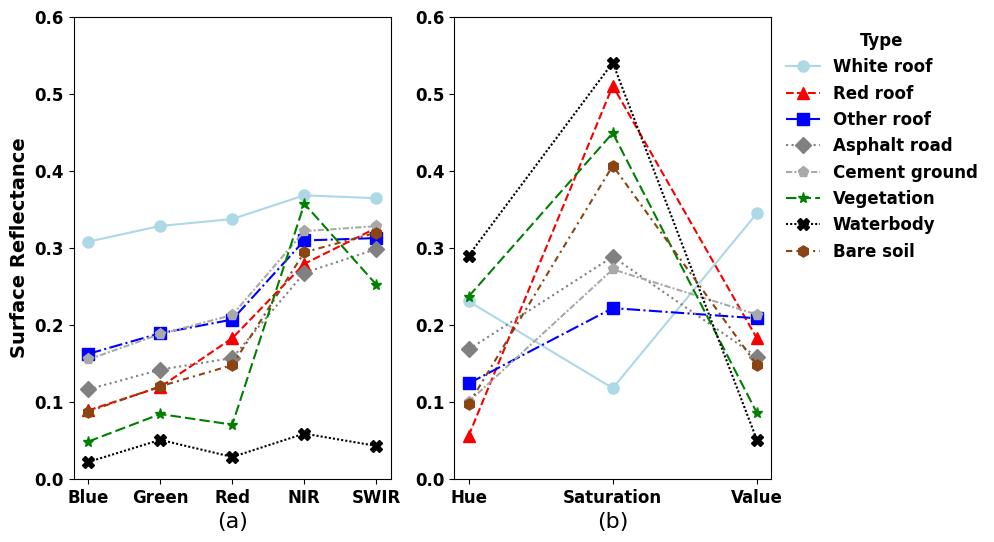

In [17]:
RGB_spec_sig = spec_sig[['Type', 'b2', 'b3', 'b4', 'b8', 'b11']].melt(id_vars='Type', var_name='Category', value_name='Val')
HSV_spec_sig = spec_sig[['Type', 'hue', 'sat', 'val']].melt(id_vars='Type', var_name='Category', value_name='Val')


# Define the category name mapping
category_mapping_rgb = {'b2': 'Blue', 'b3': 'Green', 'b4': 'Red', 'b8': 'NIR', 'b11': 'SWIR'}
category_mapping_hsv = {'hue': 'Hue', 'sat': 'Saturation', 'val': 'Value'}

# Apply the mappings before melting
spec_sig_renamed = Index_boxplot.rename(columns=category_mapping_rgb | category_mapping_hsv)

# Define the desired order of categories
type_order = ['White roof', 'Red roof', 'Other roof', 'Asphalt road', 'Cement ground', 
              'Vegetation', 'Waterbody', 'Bare soil']

# Define marker styles for each category
marker_styles = {
    'White roof': 'o',   # Dots (Circle)
    'Red roof': '^',      # Triangle
    'Other roof': 's',    # Square
    'Asphalt road': 'D',  # Diamond
    'Cement ground': 'p', # Pentagon
    'Vegetation': '*',    # Star
    'Waterbody': 'X',     # Cross
    'Bare soil': 'h'      # Hexagon
}

# Define line styles for each category
line_styles = {
    'White roof': '-',    # Solid
    'Red roof': '--',     # Dashed
    'Other roof': '-.',   # Dash-dot
    'Asphalt road': ':',  # Dotted
    'Cement ground': (0, (3, 1, 1, 1)),  # Custom dashed
    'Vegetation': (0, (5, 2)),  # Long dash
    'Waterbody': (0, (1, 1)),  # Short dash
    'Bare soil': (0, (3, 2, 1, 2))  # Mixed pattern
}

spec_sig_renamed['Type'] = pd.Categorical(spec_sig_renamed['Type'], categories=type_order, ordered=True)

RGB_spec_sig = spec_sig_renamed[['Type'] + list(category_mapping_rgb.values())].melt(
    id_vars='Type', var_name='Category', value_name='Val')
HSV_spec_sig = spec_sig_renamed[['Type'] + list(category_mapping_hsv.values())].melt(
    id_vars='Type', var_name='Category', value_name='Val')

colors = {'White roof': '#ADD8E6', 'Red roof': '#F80000', 'Other roof': '#0000FF',  'Asphalt road': '#808080',  'Cement ground': '#A9A9A9',
           'Vegetation': '#008000', 'Waterbody': '#000000', 'Bare soil': '#8B4513'}

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

# Set to greyscale: color='black', markeredgecolor='black'
for category in type_order:
    subset = RGB_spec_sig[RGB_spec_sig['Type'] == category]
    axes[0].plot(subset['Category'], subset['Val'], marker=marker_styles[category], markersize = 8, linestyle=line_styles[category], label=f'{category}', color=colors[category])

for category in type_order:
    subset = HSV_spec_sig[HSV_spec_sig['Type'] == category]
    axes[1].plot(subset['Category'], subset['Val'], marker=marker_styles[category], markersize = 8, linestyle=line_styles[category], label=f'{category}', color=colors[category])
    
axes[0].set_ylim(0, 0.6)
axes[0].set_ylabel('Surface Reflectance', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 0.6)
axes[0].set_xlabel('(a)', fontsize=16)
axes[1].set_xlabel('(b)', fontsize=16)

# Increase tick label font sizes
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# axes[1].set_ylabel('surface reflectance')
# plt.ylabel('Value')
legend = axes[1].legend(title="Type", loc="upper left", bbox_to_anchor=(1, 1), fontsize=12, frameon=False)
plt.setp(legend.get_title(), fontsize=12, fontweight='bold')  # Bold legend title
for text in legend.get_texts():
    text.set_fontweight('bold')  # Bold legend labels
    
plt.savefig("pic/Figure2_grey.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure2_grey.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show(); 

## 3. TOC Plot

### 3.1 Calculate AUC and threshold value

In [18]:
# Initialize TOC and generate TOC_NDBI
all_csv = all_csv.sort_values(['NDBI'], ascending=[False])
TOC_NDBI = TOC(all_csv['Urban'], all_csv['NDBI'], all_csv['NDBI'])
# Get the summary
TOC_NDBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.8080428316478286
The coordinate of point below top left corner: (205,128.0)


In [19]:
all_csv = all_csv.sort_values(['BU'], ascending=[False])
TOC_BU = TOC(all_csv['Urban'], all_csv['BU'], all_csv['BU'])

TOC_BU.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9158953004164188
The coordinate of point below top left corner: (205,154.0)


In [20]:
all_csv = all_csv.sort_values(['VBI'], ascending=[False])
TOC_VBI = TOC(all_csv['Urban'], all_csv['VBI'], all_csv['VBI'])

TOC_VBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9699583581201666
The coordinate of point below top left corner: (205,178.0)


In [21]:
# Search the minimum quantitative difference threshold
NDBI_sorted = all_csv.sort_values(['NDBI'], ascending=[False])
BU_sorted = all_csv.sort_values(['BU'], ascending=[False])
VBI_sorted = all_csv.sort_values(['VBI'], ascending=[False])

# Print out the threshold values when Misses equals to False Alarms (marked by the red star)
print(NDBI_sorted['NDBI'].iloc[204], BU_sorted['BU'].iloc[204], VBI_sorted['VBI'].iloc[204])

-0.0024038 -0.140442 -0.372807


In [22]:
# create Boolean images based on the threshold value
BoolNDBI = NDBI.expression('b(0) < -0.003 ? 0 : b(0) >= -0.003 ? 1 : 0').clip(roi)
m.addLayer(BoolNDBI, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean NDBI')

BoolBU =BU.expression('b(0) < -0.141 ? 0 : b(0) >= -0.141 ? 1 : 0').clip(roi)
m.addLayer(BoolBU, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean BU')

BoolVBI = VBI.expression('b(0) < -0.376 ? 0 : b(0) >= -0.356 ? 1 : 0').clip(roi)
m.addLayer(BoolVBI, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean VBI')

In [23]:
# Export threshold binary images if necessary
# geemap.ee_export_image_to_drive(BoolNDBI, description = 'BoolNDBI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BoolBUI, description = 'BoolBUI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BoolVBI, description = 'BoolVBI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)

### 3.2 Calculate the built-up area in the study area based on the threshold value of each index

In [24]:
pixel_area = ee.Image.pixelArea()
display('Pixel area default projection', pixel_area.projection())

'Pixel area default projection'

In [25]:
nonbuiltup_mask = NDBI.gt(-0.002)
builtup_NDBI = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_NDBI.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_NDBI.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters NDBI builtup', square_meters)
display('Square kilometers NDBI builtup', square_kilometers)

'Square meters NDBI builtup'

'Square kilometers NDBI builtup'

In [26]:
nonbuiltup_mask = BU.gt(-0.140)
builtup_BU = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_BU.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_BU.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters BU builtup', square_meters)
display('Square kilometers BU builtup', square_kilometers)

'Square meters BU builtup'

'Square kilometers BU builtup'

In [27]:
nonbuiltup_mask = VBI.gt(-0.373)
builtup_VBI = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_VBI.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_VBI.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters VBI builtup', square_meters)
display('Square kilometers VBI builtup', square_kilometers)

'Square meters VBI builtup'

'Square kilometers VBI builtup'

In [28]:
# Calculate the size of the study area
roi_geom = roi.geometry()

# Calculate area in square meters
area_m2 = roi_geom.area(1)

# Convert to square kilometers
area_km2 = area_m2.divide(1e6)

# Print the area
print("Study Area in square meters:", area_m2.getInfo())
print("Study Area in square kilometers:", area_km2.getInfo())

Study Area in square meters: 600994333.264216
Study Area in square kilometers: 600.9943332642135


### 3.3 generate TOC plot

In [29]:
# Functions to generate TOC (code from Liu & Pontius 2021)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as matpltColors

class TOC_painter:
    def __init__(self, TOC_list=[], index_names=[], color_list=[], marker_list=[], line_list=[], boolUniform=False, boolCorrectCorner=False):
        if type(TOC_list) != list:
            self.TOC_list = [TOC_list]
        else:
            self.TOC_list = TOC_list
        if type(color_list) != list:
            self.color_list = [color_list]
        else:
            self.color_list = color_list
        if type(marker_list) != list:
            self.marker_list = [marker_list]
        else:
            self.marker_list = marker_list
        if type(line_list) != list:
            self.line_list = [line_list]
        else:
            self.line_list = line_list
        if type(index_names) != list:
            self.index_names = [index_names]
        else:
            self.index_names = index_names

        self.totalNum = 0
        self.presenceInY = 0
        self.TOCNum = 0
        self.curve_list = []
        if len(self.TOC_list) > 0:
            if len(self.index_names) == 0:
                self.index_names = ["TOC{0}".format(i + 1) for i in range(len(self.TOC_list))]
            if len(self.color_list) == 0:
                self.color_list = ["" for _ in range(len(self.TOC_list))]
            if len(self.marker_list) == 0:
                self.marker_list = ["" for _ in range(len(self.TOC_list))]
            if len(self.line_list) == 0:
                self.line_list = ["-" for _ in range(len(self.TOC_list))]
            for i in range(len(self.TOC_list)):
                item_dic = {
                    'TOCX': self.TOC_list[i].TOCX,
                    'TOCY': self.TOC_list[i].TOCY,
                    'threshold': self.TOC_list[i].thresholdLabel,
                    'color': self.color_list[i],
                    'marker': self.marker_list[i],
                    'line': self.line_list[i],
                    'name': self.index_names[i]
                }
                self.curve_list.append(item_dic)
            self.__update_status()

        self.boolUniform = boolUniform
        self.boolCorrectCorner = boolCorrectCorner
        self.fig, self.ax = plt.subplots()

    def __update_status(self):
        self.TOCNum = len(self.curve_list)
        if self.TOCNum > 0:
            self.totalNum = self.curve_list[0]['TOCX'][0, -1]
            self.presenceInY = self.curve_list[0]['TOCY'][0, -1]

    def __addOne(self, index):
        Xlist = self.curve_list[index]['TOCX']
        Ylist = self.curve_list[index]['TOCY']
        color = self.curve_list[index]['color']
        marker = self.curve_list[index]['marker']
        line = self.curve_list[index]['line']
        Name = self.curve_list[index]['name']
        symbol = marker + line
        if len(color) == 0:
            plt.plot(Xlist[0, :], Ylist[0, :], symbol, label=Name, clip_on=False)
        else:
            plt.plot(Xlist[0, :], Ylist[0, :], symbol, color=color, label=Name, clip_on=False)
        handles, labels = plt.gca().get_legend_handles_labels()
        numCurve = len(handles)
        if labels[0] == 'Uniform':
            order = list(range(1, numCurve))
            order.extend([0])
        else:
            order = list(range(0, numCurve))
        plt.gca().legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1, 0.5))

    def __format_coordinates(self, TOCX, TOCY):
        TOCX = np.array(TOCX).flatten()
        TOCX = TOCX.reshape((1, TOCX.shape[0]))
        TOCY = np.array(TOCY).flatten()
        TOCY = TOCY.reshape((1, TOCY.shape[0]))
        return TOCX, TOCY

    def add_correct_corner(self, index):
        TOCX = self.curve_list[index]['TOCX']
        TOCY = self.curve_list[index]['TOCY']
        presenceInY = TOCY[0, -1]
        bool_presence = (TOCX <= presenceInY).astype(int)
        corner_index = bool_presence.sum() - 1
        if corner_index == TOCY.shape[1] - 1:
            y_res = TOCX[0, -1]
        else:
            y_res = (TOCY[0, corner_index + 1] - TOCY[0, corner_index]) * 1.0 / (
                        TOCX[0, corner_index + 1] - TOCX[0, corner_index]) * (presenceInY - TOCX[0, corner_index]) + TOCY[0, corner_index] * 1.0
        plt.plot(presenceInY, y_res, 'r*', zorder=20)

    def add_all_correct_corner(self):
        for i in range(self.TOCNum):
            self.add_correct_corner(i)

    def add_TOC(self, TOC, index_name=None, color='', marker='', line='-'):
        self.__update_status()
        if index_name is None:
            index_list = [j['name'] for j in self.curve_list]
            for i in range(1, self.TOCNum + 2):
                if 'TOC' + str(i) not in index_list:
                    index_name = 'TOC' + str(i)
                    break
        item_dic = {
            'TOCX': TOC.TOCX,
            'TOCY': TOC.TOCY,
            'threshold': TOC.thresholdLabel,
            'color': color,
            'marker': marker,
            'line': line,
            'name': index_name
        }
        self.curve_list.append(item_dic)
        self.__update_status()

    def add_TOC_coor(self, TOCX, TOCY, threshold=[], index_name=None, color='', marker='', line='-'):
        self.__update_status()
        if index_name is None:
            index_list = [j['name'] for j in self.curve_list]
            for i in range(1, self.TOCNum + 2):
                if 'TOC' + str(i) not in index_list:
                    index_name = 'TOC' + str(i)
                    break
        TOCX, TOCY = self.__format_coordinates(TOCX, TOCY)
        item_dic = {
            'TOCX': TOCX,
            'TOCY': TOCY,
            'threshold': threshold,
            'color': color,
            'marker': marker,
            'line': line,
            'name': index_name
        }
        self.curve_list.append(item_dic)
        self.__update_status()

    def paint(self):
        self.__update_status()
        cmap = matpltColors.ListedColormap(['#e0e0e0'])

        # Define vertices for the triangles
        vertices = np.array([[self.totalNum - self.presenceInY, 0],
                             [self.totalNum, 0],
                             [self.totalNum, self.presenceInY],
                             [0, 0],
                             [0, self.presenceInY],
                             [self.presenceInY, self.presenceInY]])

        # Define the triangles using vertex indices
        triangles = np.array([[0, 1, 2],
                              [3, 4, 5]])

        # Define the face colors, one for each triangle
        facecolors = np.array([1, 1])  # Array length must match the number of triangles

        plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, facecolors=facecolors, edgecolor="k", lw=0, cmap=cmap)

        plt.axis('square')
        plt.axis([0, self.totalNum, 0, self.presenceInY])
        plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
        if self.boolCorrectCorner:
            plt.text(0, self.presenceInY * 1.01, 'The red star marks where False Alarms equals Misses.', color="black", fontsize=8)
        if self.boolUniform:
            plt.plot([0, self.totalNum], [0, self.presenceInY], ':', color="violet", label='Uniform')
        
        for i in range(self.TOCNum):
            self.__addOne(i)
        plt.savefig("pic/Figure4.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
        plt.savefig("pic/Figure4.pdf", dpi=1200, format="pdf", bbox_inches="tight")
        plt.show()


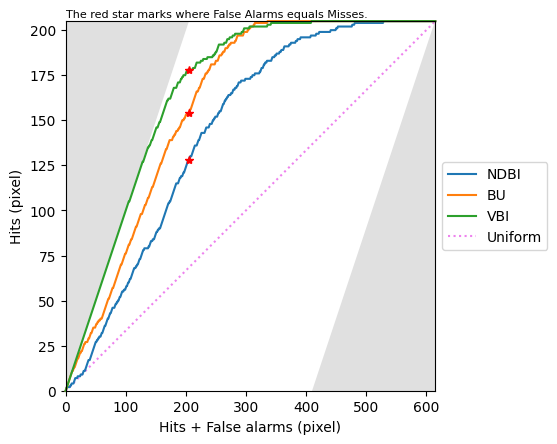

In [30]:
# Assuming TOC_NDBI, TOC_BUI, TOC_VBI are instances of the TOC class with the necessary attributes
TOC_list = [TOC_NDBI, TOC_BU, TOC_VBI]
index_names = ["NDBI", "BU", "VBI"]

toc_painter = TOC_painter(TOC_list=TOC_list, index_names=index_names, boolUniform=True, boolCorrectCorner=True)
plt.xlabel('Hits + False alarms (pixel)')
plt.ylabel('Hits (pixel)')
toc_painter.add_all_correct_corner()
toc_painter.paint()

In [31]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure4.jpg").convert("L")
img.save("pic/Figure4_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure4_greyscale.jpg")  # Overwrite with grayscale version

## 4. Boxplot Generation

In [32]:
# generate the boxplot and the 2 SD difference plot
Index_boxplot = all_csv
Index_boxplot['Type'].replace(1, "White", inplace=True)
Index_boxplot['Type'].replace(2, "Red", inplace=True)
Index_boxplot['Type'].replace(3, "Other", inplace=True)
Index_boxplot['Type'].replace(4, "Road", inplace=True)
Index_boxplot['Type'].replace(6, "Ground", inplace=True)
Index_boxplot['Type'].replace(7, "Vegetation", inplace=True)
Index_boxplot['Type'].replace(8, "Water", inplace=True)
Index_boxplot['Type'].replace(9, "Soil", inplace=True)

Index_boxplot['Urban'].replace(0, "Non-Built-up", inplace=True)
Index_boxplot['Urban'].replace(1, "Built-up", inplace=True)

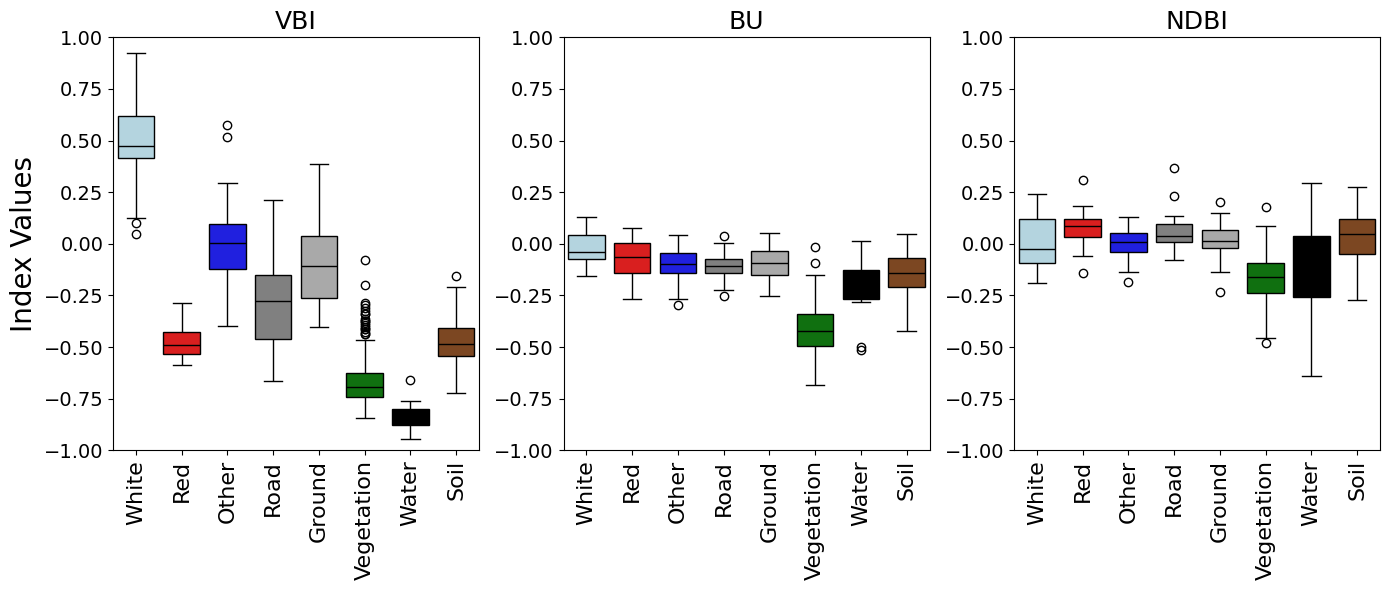

In [33]:
palette = {'White': '#ADD8E6', 'Red': '#F80000', 'Other': '#0000FF',  'Road': '#808080',  'Ground': '#A9A9A9',
           'Vegetation': '#008000', 'Water': '#000000', 'Soil': '#8B4513'}
bp_order = ['White', 'Red', 'Other', 'Road', 'Ground', 'Vegetation', 'Water', 'Soil']

# Define font sizes
axis_fontsize = 20  # Font size for labels
title_fontsize = 18  # Font size for titles
tick_fontsize = 14  # Font size for tick labels
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(ax=axes[0], x='Type', y='VBI', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[0].set_ylim(-1, 1)
axes[0].set_title('VBI', fontsize=title_fontsize)
axes[0].set_xlabel('')
axes[0].set_ylabel('Index Values', fontsize=axis_fontsize)
axes[0].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[1], x='Type', y='BU', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[1].set_ylim(-1, 1)
axes[1].set_title('BU', fontsize=title_fontsize)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[2], x='Type', y='NDBI', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[2].set_ylim(-1, 1)
axes[2].set_title('NDBI', fontsize=title_fontsize)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[2].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig("pic/Figure8.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure8.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [34]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure8.jpg").convert("L")
img.save("pic/Figure8_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure8_greyscale.jpg")  # Overwrite with grayscale version

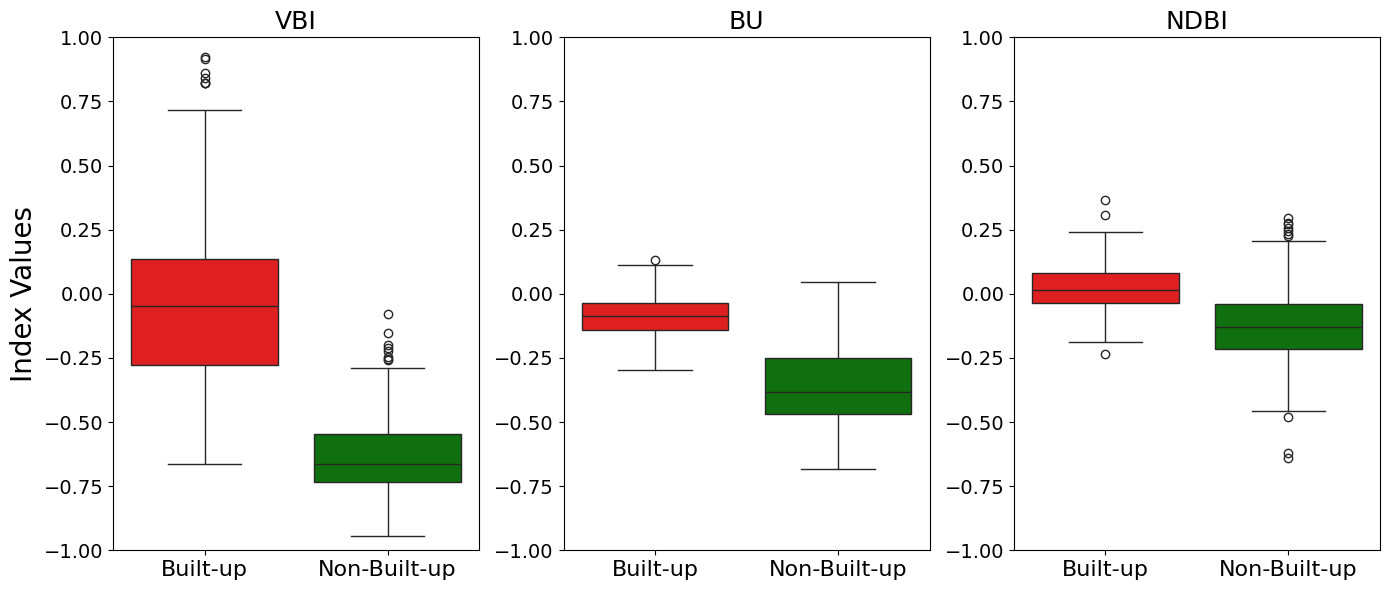

In [35]:
palette = {'Built-up': 'red', 'Non-Built-up': 'green'}
bp_order = ['Built-up', 'Non-Built-up']
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Define font sizes
axis_fontsize = 20  # Font size for labels
title_fontsize = 18  # Font size for titles
tick_fontsize = 14  # Font size for tick labels

sns.boxplot(ax=axes[0], x='Urban', y='VBI', data=Index_boxplot, palette=palette, order=bp_order)
axes[0].set_ylim(-1, 1)
axes[0].set_title('VBI', fontsize=title_fontsize)
axes[0].set_xlabel('')
axes[0].set_ylabel('Index Values', fontsize=axis_fontsize)
axes[0].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[1], x='Urban', y='BU', data=Index_boxplot, palette=palette, order=bp_order)
axes[1].set_ylim(-1, 1)
axes[1].set_title('BU', fontsize=title_fontsize)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[2], x='Urban', y='NDBI', data=Index_boxplot, palette=palette, order=bp_order)
axes[2].set_ylim(-1, 1)
axes[2].set_title('NDBI', fontsize=title_fontsize)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[2].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.savefig("pic/Figure7.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure7.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [36]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure7.jpg").convert("L")
img.save("pic/Figure7_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure7_greyscale.jpg")  # Overwrite with grayscale version

## 5. Statistical Importance Analysis

In [37]:
# Load all_csv again to avoid errors
all_csv = pd.read_csv(cwp + "/data/20250205_615sample_ALL.csv")
# Rename BUI to BU
all_csv.rename(columns={"BUI": "BU"}, inplace=True)
# Standardize BU
all_csv['BU'] = all_csv['BU'] / 2

In [38]:
# Perform Mann-Whitney U Test for Urban vs. Non-Urban for VBI, BUI, and NDBI
urban_vbi = all_csv[all_csv['Urban'] == 1]['VBI']
non_urban_vbi = all_csv[all_csv['Urban'] == 0]['VBI']

urban_bui = all_csv[all_csv['Urban'] == 1]['BU']
non_urban_bui = all_csv[all_csv['Urban'] == 0]['BU']

urban_ndbi = all_csv[all_csv['Urban'] == 1]['NDBI']
non_urban_ndbi = all_csv[all_csv['Urban'] == 0]['NDBI']

# Perform Mann-Whitney U Test for each index
vbi_stat, vbi_p = stats.mannwhitneyu(urban_vbi, non_urban_vbi, alternative='two-sided')
bui_stat, bui_p = stats.mannwhitneyu(urban_bui, non_urban_bui, alternative='two-sided')
ndbi_stat, ndbi_p = stats.mannwhitneyu(urban_ndbi, non_urban_ndbi, alternative='two-sided')

# Store results in a dictionary
mann_whitney_results = {
    "VBI": {"Statistic": vbi_stat, "P-value": vbi_p},
    "BU": {"Statistic": bui_stat, "P-value": bui_p},
    "NDBI": {"Statistic": ndbi_stat, "P-value": ndbi_p}
}

# Interpretation
for metric, result in mann_whitney_results.items():
    result["Conclusion"] = "Significant difference" if result["P-value"] < 0.05 else "No significant difference"

# Display results
mann_whitney_results


{'VBI': {'Statistic': 81525.0,
  'P-value': 1.2531454186621906e-80,
  'Conclusion': 'Significant difference'},
 'BU': {'Statistic': 76981.0,
  'P-value': 1.5072618587796505e-63,
  'Conclusion': 'Significant difference'},
 'NDBI': {'Statistic': 67916.0,
  'P-value': 1.1672749871559839e-35,
  'Conclusion': 'Significant difference'}}

In [39]:
# Since normality and homogeneity assumptions are violated for VBI and BU, ANOVA might not be fully reliable.
# Recommended Alternative: Use the Kruskal-Wallis Test (Non-Parametric ANOVA) for these variables.
# Use Dunn’s Post-Hoc Test for multi-groups comparisons.

# 1. Run Kruskal-Wallis test

variables = ['VBI', 'BU', 'NDBI']

# Dictionary to store results
kruskal_results_land_cover = {}

# Perform Kruskal-Wallis Test for each variable across land cover types
for variable in variables:
    groups = [all_csv[all_csv['Type'] == t][variable].dropna() for t in all_csv['Type'].unique()]
    kruskal_stat, p_value = stats.kruskal(*groups)
    
    # Store results
    kruskal_results_land_cover[variable] = {
        "Kruskal-Wallis Statistic": kruskal_stat,
        "P-value": p_value
    }

    # Interpretation
    if p_value < 0.05:
        kruskal_results_land_cover[variable]["Conclusion"] = f"There is a significant difference in {variable} among the 8 land cover types."
    else:
        kruskal_results_land_cover[variable]["Conclusion"] = f"No significant difference in {variable} among the 8 land cover types."

# Print the results
for variable, result in kruskal_results_land_cover.items():
    print(f"\n{variable} Kruskal-Wallis Test Results:")
    print(f"Statistic: {result['Kruskal-Wallis Statistic']:.4f}, P-value: {result['P-value']:.4e}")
    print(f"Conclusion: {result['Conclusion']}")




VBI Kruskal-Wallis Test Results:
Statistic: 465.7195, P-value: 1.8669e-96
Conclusion: There is a significant difference in VBI among the 8 land cover types.

BU Kruskal-Wallis Test Results:
Statistic: 431.7598, P-value: 3.6605e-89
Conclusion: There is a significant difference in BU among the 8 land cover types.

NDBI Kruskal-Wallis Test Results:
Statistic: 310.6975, P-value: 3.1375e-63
Conclusion: There is a significant difference in NDBI among the 8 land cover types.


In [40]:
# Perform Dunn's test with Bonferroni correction for multiple comparisons
dunn_results_bu = sp.posthoc_dunn(all_csv, val_col='BU', group_col='Type', p_adjust='bonferroni')
dunn_results_ndbi = sp.posthoc_dunn(all_csv, val_col='NDBI', group_col='Type', p_adjust='bonferroni')
dunn_results_vbi = sp.posthoc_dunn(all_csv, val_col='VBI', group_col='Type', p_adjust='bonferroni')

dunn_results_vbi

,1,2,3,4,6,7,8,9
1,1.000000e+00,0.000170,1.000000e+00,9.387954e-03,3.070285e-01,1.453615e-39,1.289640e-19,1.654450e-10
2,1.703343e-04,1.000000,2.285617e-02,1.000000e+00,1.495494e-01,1.472896e-03,4.842555e-05,1.000000e+00
3,1.000000e+00,0.022856,1.000000e+00,9.420668e-01,1.000000e+00,6.909039e-46,1.229060e-16,1.916203e-07
4,9.387954e-03,1.000000,9.420668e-01,1.000000e+00,1.000000e+00,2.993910e-12,1.922036e-09,8.984024e-01
6,3.070285e-01,0.149549,1.000000e+00,1.000000e+00,1.000000e+00,2.759704e-31,2.121581e-14,1.295429e-04
7,1.453615e-39,0.001473,6.909039e-46,2.993910e-12,2.759704e-31,1.000000e+00,1.909862e-01,1.028219e-14
8,1.289640e-19,0.000048,1.229060e-16,1.922036e-09,2.121581e-14,1.909862e-01,1.000000e+00,2.028695e-07
9,1.654450e-10,1.000000,1.916203e-07,8.984024e-01,1.295429e-04,1.028219e-14,2.028695e-07,1.000000e+00


In [41]:
# Function to convert a square matrix into a lower triangular format with NaNs
def make_lower_triangular(df):
    matrix = df.copy()
    mask = np.triu(np.ones(matrix.shape), k=1)  # Create upper triangular mask
    matrix = matrix.mask(mask == 1, np.nan)  # Apply NaN to upper triangle
    return matrix

# Assuming the data is similar to Dunn's test output, process it into a lower triangular format
triangular_ndbi = make_lower_triangular(dunn_results_ndbi)
triangular_bu = make_lower_triangular(dunn_results_bu)
triangular_vbi = make_lower_triangular(dunn_results_vbi)

In [42]:
triangular_ndbi

,1,2,3,4,6,7,8,9
1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN
4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN
6,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
7,5.012844e-11,1.364073e-10,1.470777e-22,6.090174e-16,4.068257e-18,1.000000e+00,NaN,NaN
8,6.541807e-01,2.609214e-02,1.588547e-01,1.741487e-02,1.633089e-01,1.000000e+00,1.000000,NaN
9,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.709779e-33,0.029978,1.0


In [43]:
# Define a mapping of numbers to labels
rename_dict = {
    1: "White",
    2: "Red",
    3: "Other",
    4: "Road",
    6: "Ground",
    7: "Vegetation",
    8: "Water",
    9: "Soil"
}

# Rename the index and columns of the triangular NDBI, BU, and VBI matrix
triangular_ndbi_renamed = triangular_ndbi.rename(index=rename_dict, columns=rename_dict)
triangular_bu_renamed = triangular_bu.rename(index=rename_dict, columns=rename_dict)
triangular_vbi_renamed = triangular_vbi.rename(index=rename_dict, columns=rename_dict)

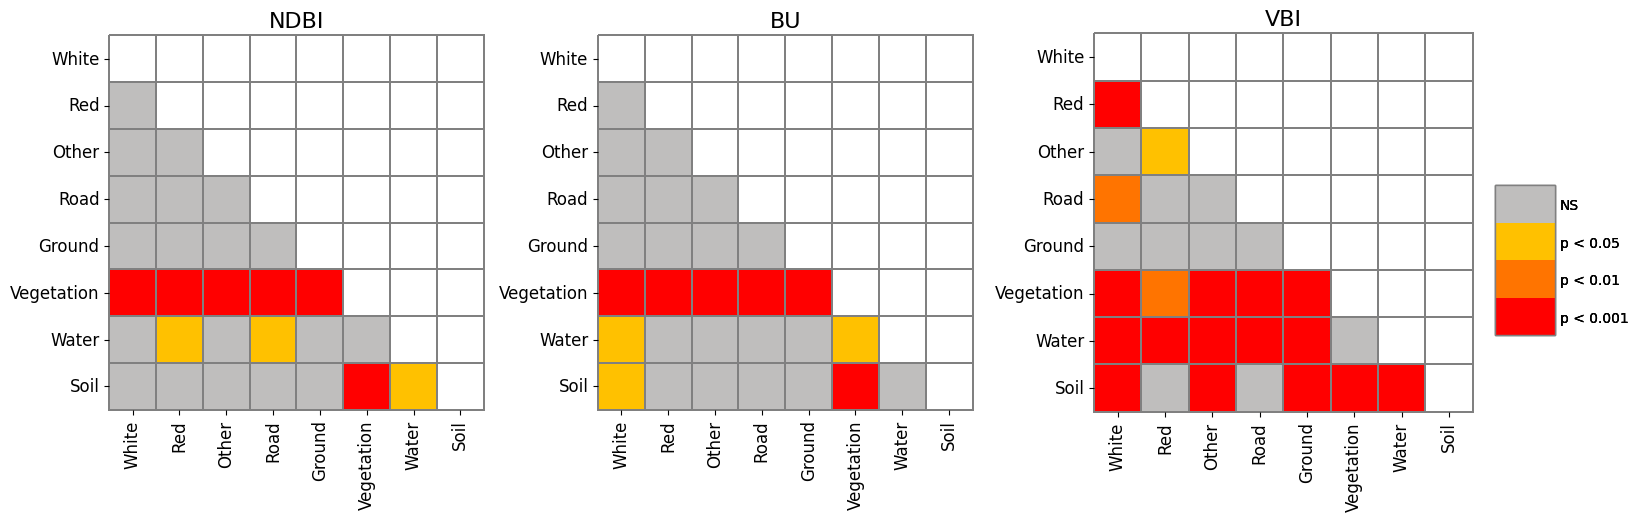

In [45]:
cmap = ['1', '#bfbebd',  '#ff0000',  '#ff7400', '#ffc100']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [1, 0.35, 0.04, 0.3], 'cbar_kws': {'shrink': 0.8, 'labelsize': 16}}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.05]})  

sp.sign_plot(triangular_ndbi_renamed, ax=axes[0], **heatmap_args)
axes[0].set_title("NDBI", fontsize=16)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

sp.sign_plot(triangular_bu_renamed, ax=axes[1], **heatmap_args)
axes[1].set_title("BU", fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

sp.sign_plot(triangular_vbi_renamed, ax=axes[2], **heatmap_args)
axes[2].set_title("VBI", fontsize=16)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)

# Adjust the figure layout and add a colorbar outside the plots
# cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])  # [x-position, y-position, width, height]
# fig.colorbar(im.collections[0], cax=cbar_ax)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("pic/Figure9.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure9.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [46]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure9.jpg").convert("L")
# img.save("pic/Figure8b_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure9_greyscale.jpg")  # Overwrite with grayscale version